Accuracy: 0.80


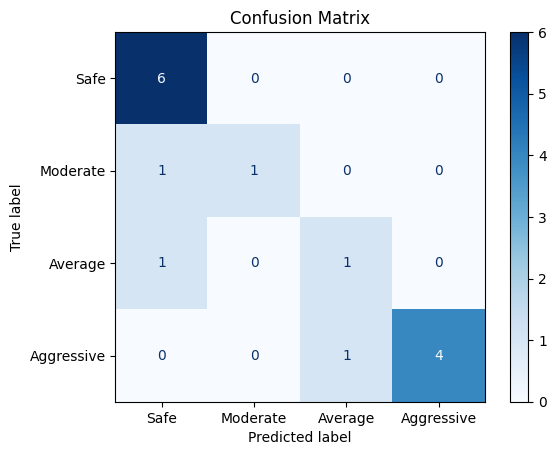

              precision    recall  f1-score   support

        Safe       0.75      1.00      0.86         6
    Moderate       1.00      0.50      0.67         2
     Average       0.50      0.50      0.50         2
  Aggressive       1.00      0.80      0.89         5

    accuracy                           0.80        15
   macro avg       0.81      0.70      0.73        15
weighted avg       0.83      0.80      0.79        15



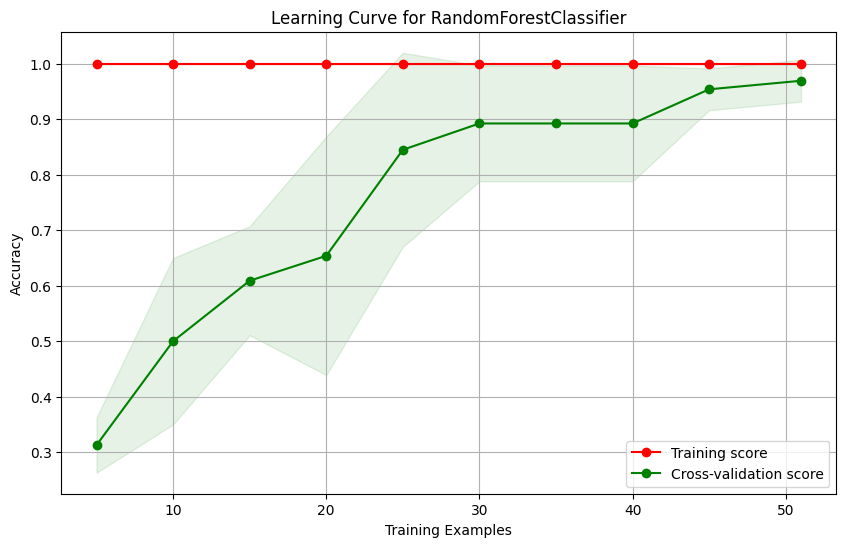

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

# Load your dataset
data = pd.read_csv('../data/driving_data.csv')

# Feature Engineering
trip_features = data.groupby('TripId').agg(
    avg_speed=('Speed(km/h)', 'mean'),
    max_acceleration=('Acceleration(m/s^2)', 'max'),
    total_heading_change=('Heading_Change(degrees)', 'sum')
).reset_index()

# Categorize driver behavior into 4 classes
def categorize_behavior(row):
    if row['avg_speed'] > 70 or row['max_acceleration'] > 3:
        return 3  # Aggressive
    elif row['avg_speed'] > 60:
        return 2  # Average
    elif row['avg_speed'] > 50:
        return 1  # Moderate
    else:
        return 0  # Safe

trip_features['behavior_category'] = trip_features.apply(categorize_behavior, axis=1)

# Features and labels
X = trip_features[['avg_speed', 'max_acceleration', 'total_heading_change']]
y = trip_features['behavior_category']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply RandomOverSampler to handle class imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe', 'Moderate', 'Average', 'Aggressive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Safe', 'Moderate', 'Average', 'Aggressive']))

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Plot learning curve with resampled data
train_sizes, train_scores, test_scores = learning_curve(
    model, X_resampled, y_resampled, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate the mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for RandomForestClassifier")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()
